# Fashion-MNIST

In [1]:
import torch
from torchvision import datasets, transforms
from typing import Sized, cast

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  # Fashion-MNIST mean and std
])

train_data = datasets.FashionMNIST(
    root="./data/ignored",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data/ignored",
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

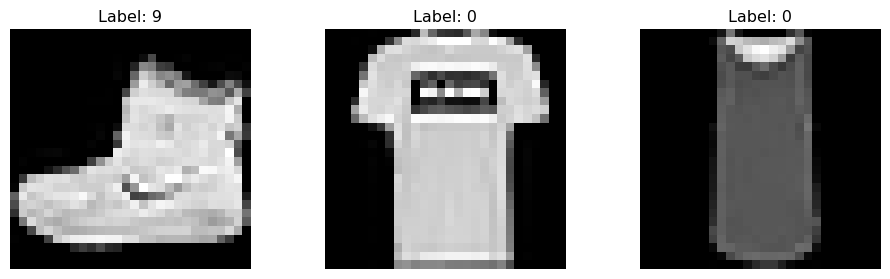

In [2]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    img, label = train_data[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.tight_layout()

In [3]:
import torch.nn as nn


class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FashionCNN().to(device)

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(cast(Sized, train_loader.dataset))
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.6202
Epoch [2/10], Loss: 0.4135
Epoch [3/10], Loss: 0.3626
Epoch [4/10], Loss: 0.3342
Epoch [5/10], Loss: 0.3046
Epoch [6/10], Loss: 0.2877
Epoch [7/10], Loss: 0.2704
Epoch [8/10], Loss: 0.2594
Epoch [9/10], Loss: 0.2503
Epoch [10/10], Loss: 0.2374

In [7]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / len(cast(Sized, test_loader.dataset))
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.08%